<a href="https://colab.research.google.com/github/m10k1/ml-learn/blob/main/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SRCNNを使った超解像度画像生成

Caifar10を使用する



In [31]:
from io import IncrementalNewlineDecoder

import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.transforms.functional import resize

import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook


# pytorch のバージョン確認
print(torch.__version__)


2.5.1+cu121


In [32]:

transform = transforms.Compose([
    transforms.ToTensor()
])


# データのダウンロード
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [33]:

print(train_dataset.meta)
print(train_dataset.data.shape)

print(train_dataset.targets[:10])

{'filename': 'batches.meta', 'key': 'label_names', 'md5': '5ff9c542aee3614f3951f8cda6e48888'}
(50000, 32, 32, 3)
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


In [34]:
# データローダーの作成

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = train_dataset.classes

# 0番目のミニバッチの画像とラベルを取得
images, labels = train_dataset[0]
print(f"image shape: {images.shape}")
print(f"label: {classes[labels]}")


image shape: torch.Size([3, 32, 32])
label: frog


Class name : frog


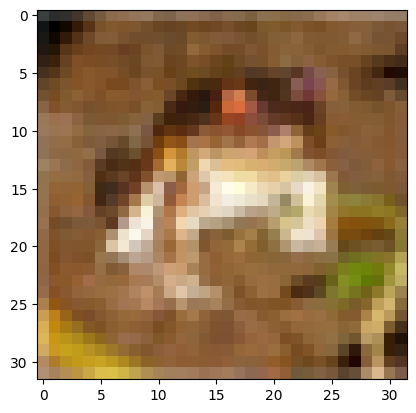

In [35]:

# 画像の表示
# permuteで c h, w ->　h, w, cの順にする
idx = 0
print(f"Class name : {classes[train_dataset[idx][1]]}")
plt.show()
plt.imshow(train_dataset[idx][0].permute(1, 2, 0))


Class name : truck


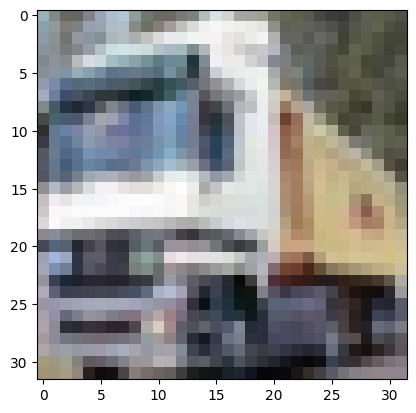

In [36]:
idx = 1
print(f"Class name : {classes[train_dataset[idx][1]]}")
plt.imshow(train_dataset[idx][0].permute(1, 2, 0))

## 低解像度の画像を作成する

３２ｘ３２の画像を１６ｘ１６にリサイズしてから、
BICUBICで３２ｘ３２にリサイズして低解像度画像を作成する

In [37]:
from torchvision.transforms.functional import resize
from torchvision.transforms.functional import InterpolationMode

# リサイズで小さくしてからサイズを戻して解像度を落とす
def downsample_image(image, scale_factor):
  low_res = resize(image, [image.shape[1] // scale_factor, image.shape[2] // scale_factor])
  low_res = resize(low_res, [low_res.shape[1] * scale_factor, low_res.shape[2] * scale_factor ], interpolation=InterpolationMode.BICUBIC)
  return low_res

# 低解像度画像と高解像度画像のペアを作成
scale_factor = 2  # 解像度倍率

def create_low_high_res_pairs(images, scale_factor):
  low_res_images = [downsample_image(img, scale_factor) for img in images]
  high_res_images = images
  return low_res_images, high_res_images

In [38]:
# train_datasetの画像から低解像度、高解像度の画像を生成
sample_images= [train_dataset[i][0] for i in range(10)]

low_res_images, high_res_images = create_low_high_res_pairs(sample_images, scale_factor)


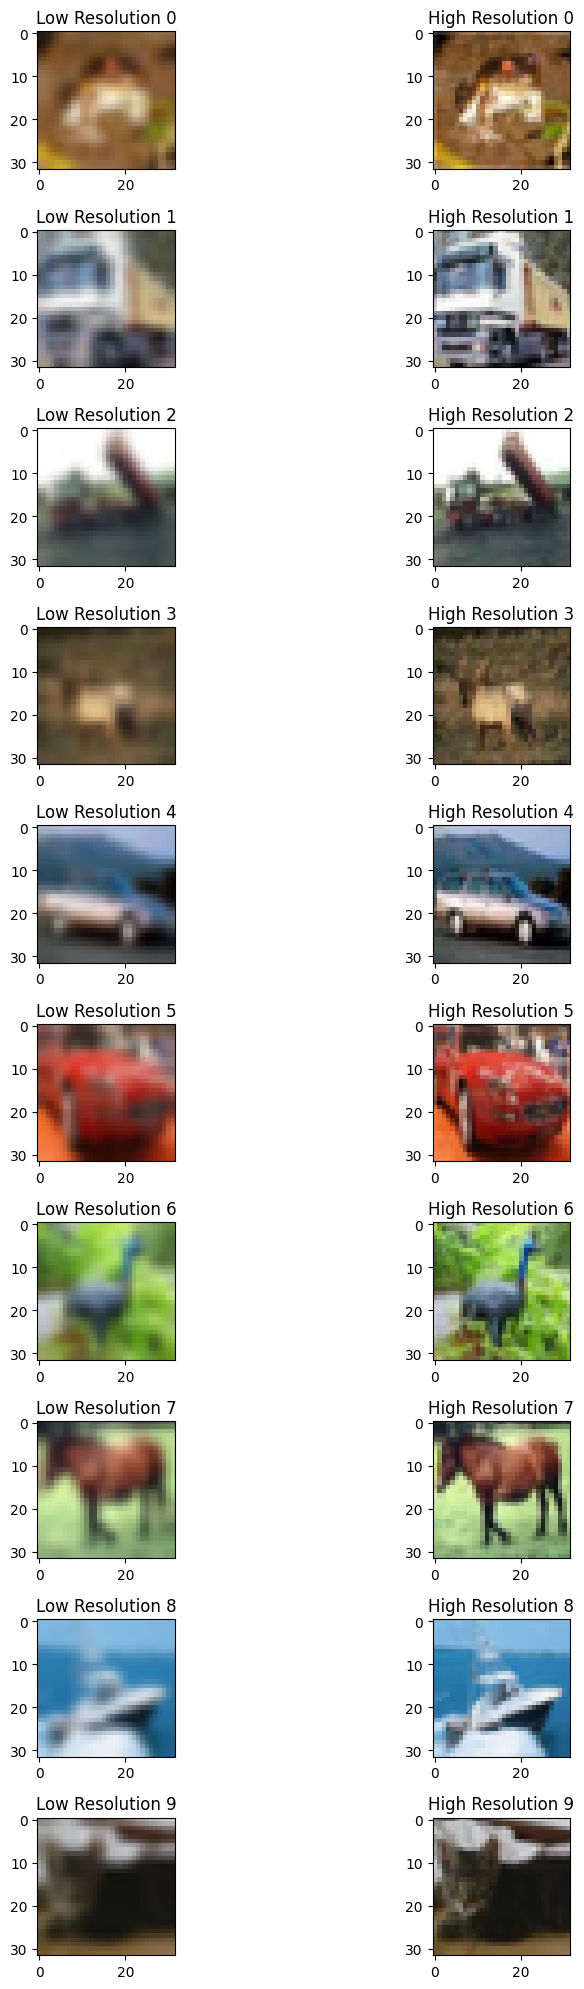

In [39]:
# low_res_imagesとhigh_res_imagesを並べて表示して比較する
# 画像の表示
fig, axes = plt.subplots(nrows=len(low_res_images), ncols=2, figsize=(10, 20))

for i in range(len(low_res_images)):
  axes[i, 0].imshow(low_res_images[i].permute(1, 2, 0))
  axes[i, 0].set_title(f"Low Resolution {i}")
  axes[i, 1].imshow(high_res_images[i].permute(1, 2, 0))
  axes[i, 1].set_title(f"High Resolution {i}")

plt.tight_layout()
plt.show()

# モデルの構築
SRCNN(Super-Resolution Convolutional Neural Network)を使って画像の超解像度処理を行う




In [40]:
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=9 // 2)  # 入力チャネル: 3（RGB）
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding= 5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# モデルのインスタンス化
model = SRCNN()
print(model)

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)


In [41]:
import torch.optim as optim

# 損失関数とオプティマイザ
criterion = nn.MSELoss()  # ピクセル単位の差を計算
optimizer = optim.Adam(model.parameters(), lr=0.001)

## トレーニングの実行


In [42]:
import torch
from tqdm import tqdm

# トレーニング
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for images, _ in tqdm(train_loader):
        # 高解像度と低解像度のペアを作成
        low_res, high_res = create_low_high_res_pairs(images, scale_factor)

        # デバイスに転送
        low_res = torch.stack(low_res).to(device)
        high_res = high_res.to(device)


        # 順伝播
        outputs = model(low_res)
        loss = criterion(outputs, high_res)

        # 逆伝播とパラメータ更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")


100%|██████████| 782/782 [00:23<00:00, 33.06it/s]


Epoch [1/10], Loss: 0.0068


100%|██████████| 782/782 [00:23<00:00, 32.95it/s]


Epoch [2/10], Loss: 0.0028


100%|██████████| 782/782 [00:23<00:00, 32.62it/s]


Epoch [3/10], Loss: 0.0025


100%|██████████| 782/782 [00:24<00:00, 32.52it/s]


Epoch [4/10], Loss: 0.0024


100%|██████████| 782/782 [00:24<00:00, 32.55it/s]


Epoch [5/10], Loss: 0.0023


100%|██████████| 782/782 [00:24<00:00, 32.47it/s]


Epoch [6/10], Loss: 0.0023


100%|██████████| 782/782 [00:24<00:00, 32.44it/s]


Epoch [7/10], Loss: 0.0022


100%|██████████| 782/782 [00:24<00:00, 32.32it/s]


Epoch [8/10], Loss: 0.0022


100%|██████████| 782/782 [00:23<00:00, 32.60it/s]


Epoch [9/10], Loss: 0.0022


100%|██████████| 782/782 [00:24<00:00, 32.50it/s]

Epoch [10/10], Loss: 0.0021


## テストデータに対してモデルを適用
テストデータに対してモデルを適用して表示
主観的な評価を行う

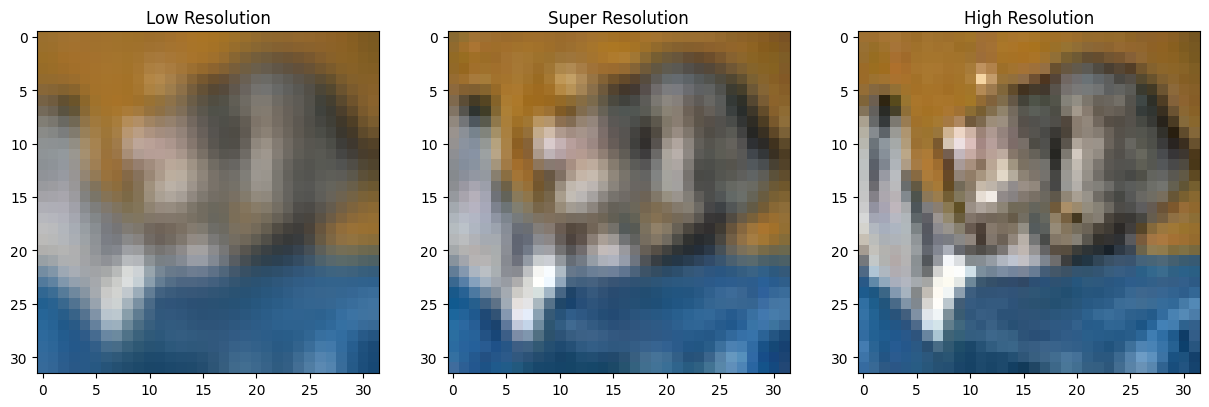

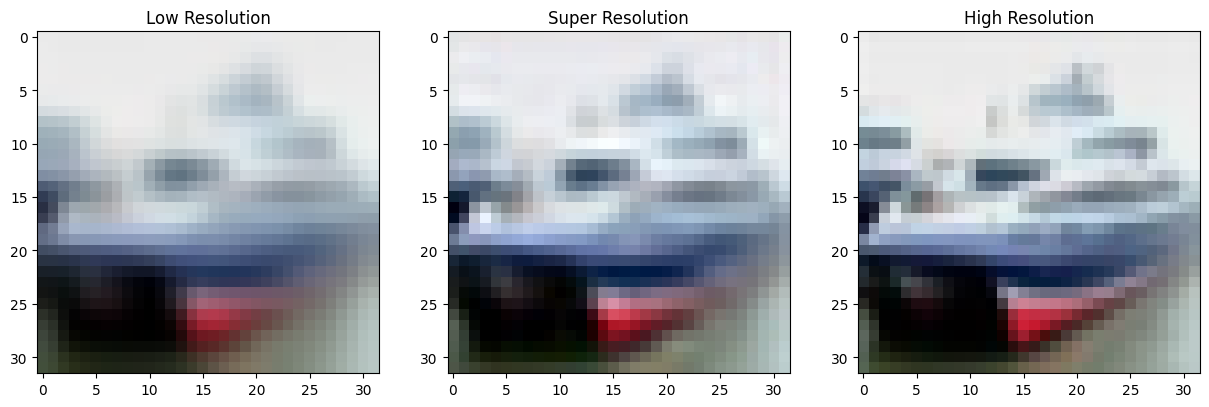

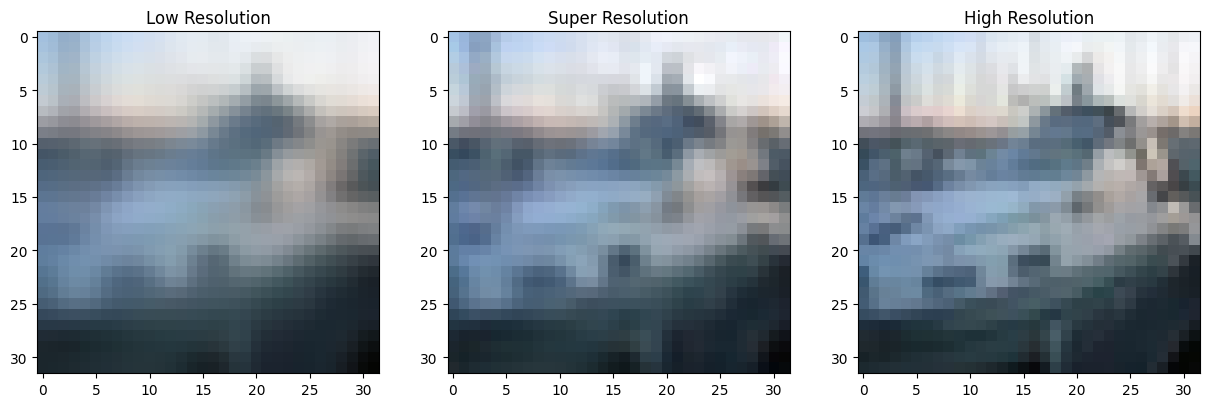

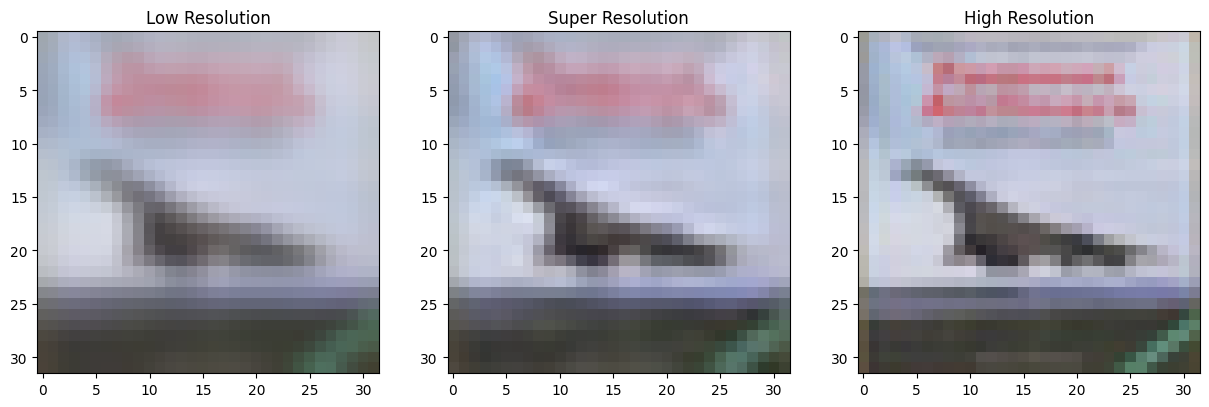

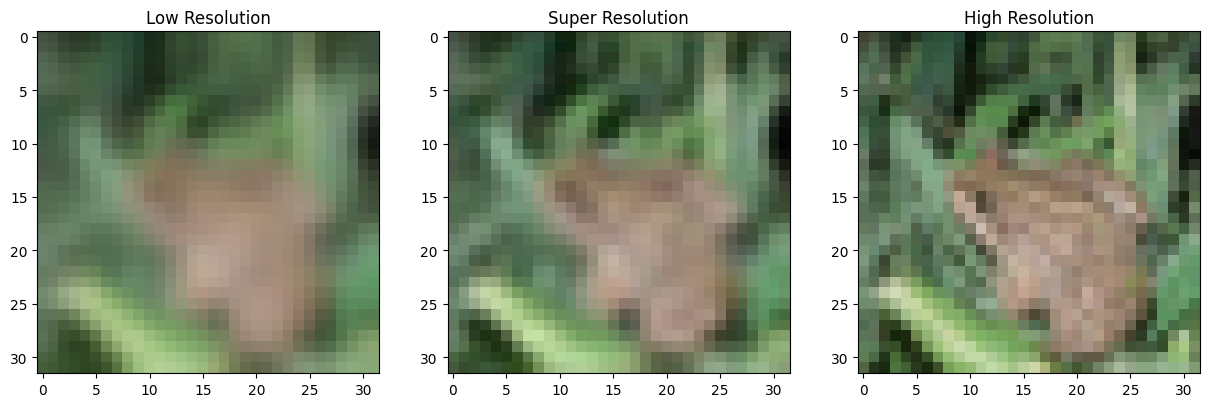

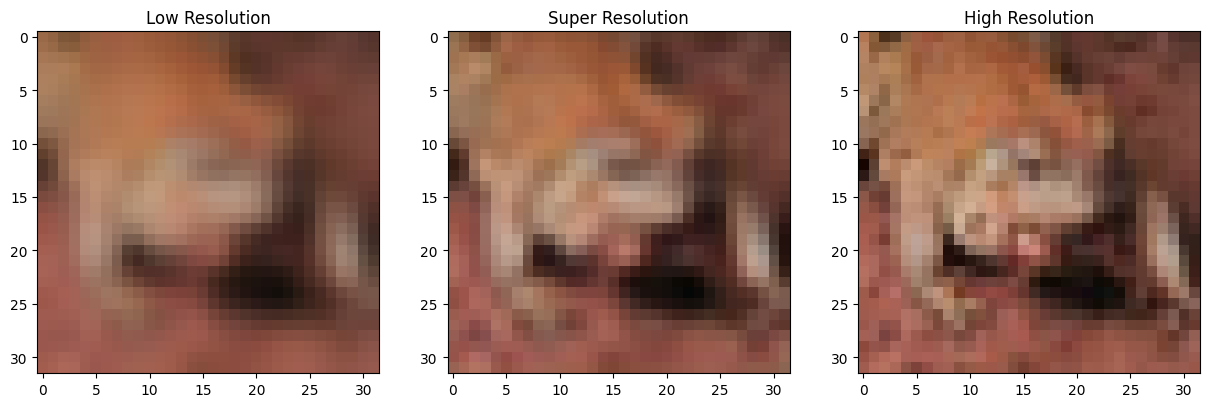

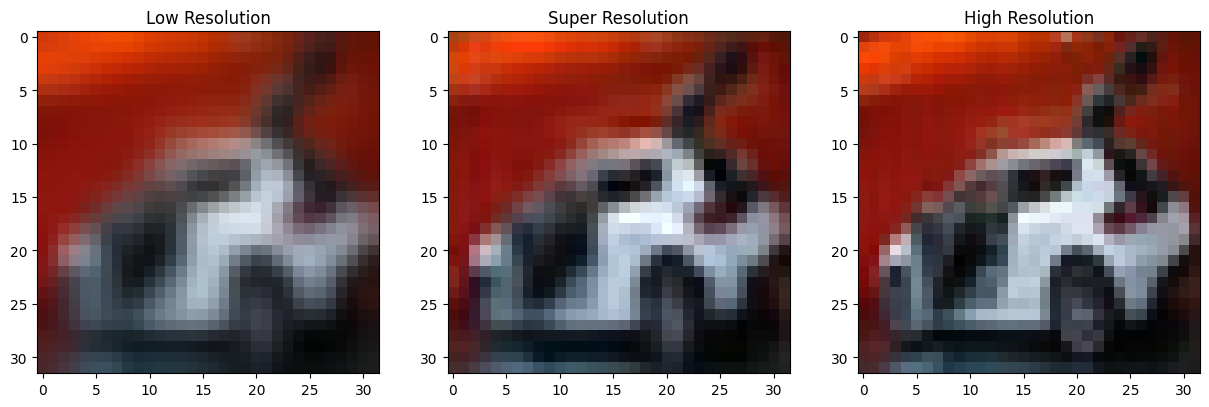

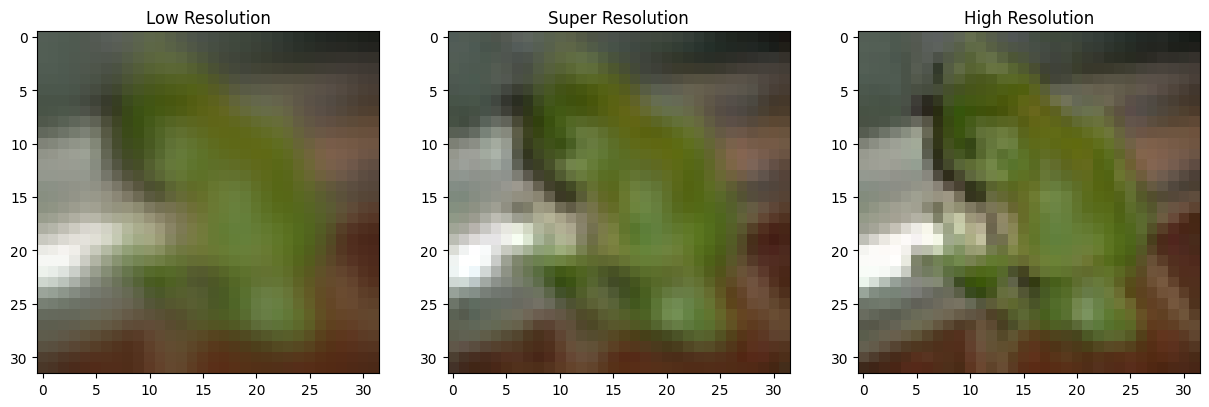

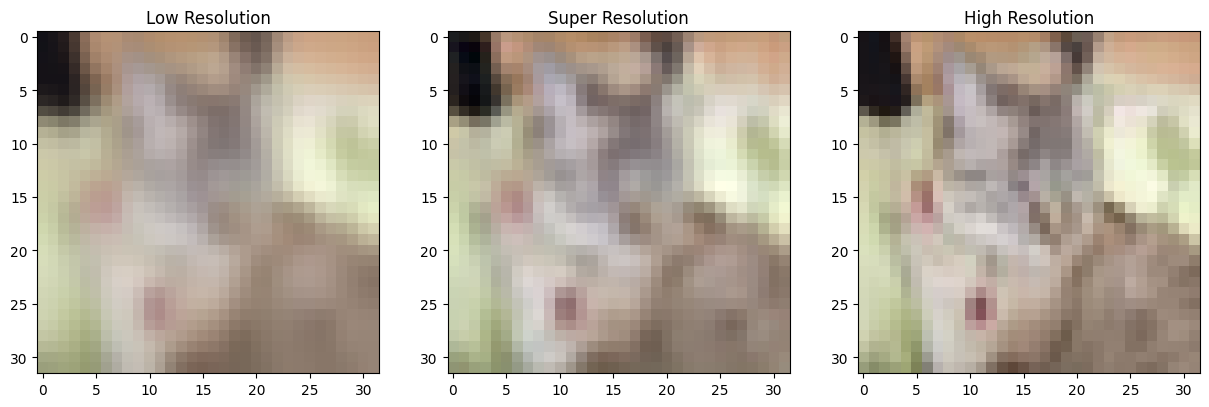

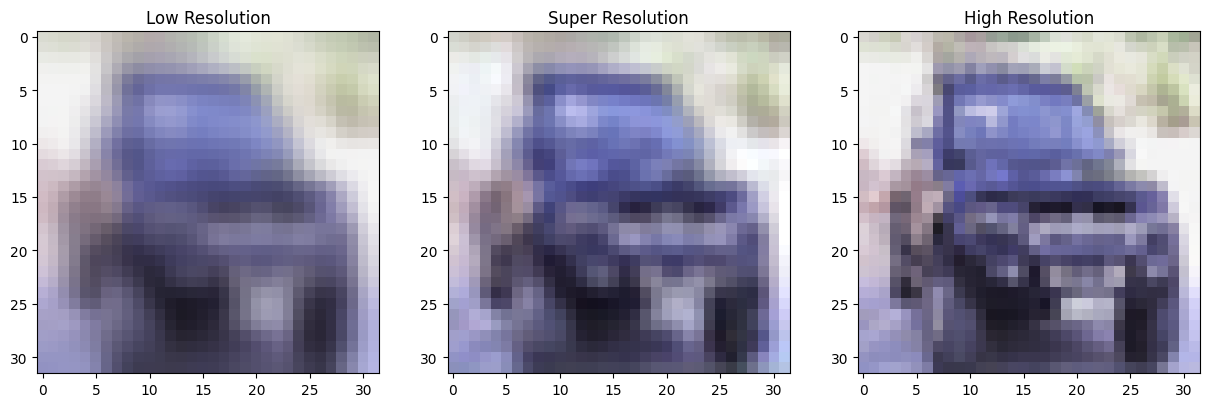

In [43]:
import matplotlib.pyplot as plt

# 画像を可視化
def show_images(low_res, high_res, output):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(low_res.permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Low Resolution")
    axs[1].imshow(output.permute(1, 2, 0).detach().cpu().numpy())
    axs[1].set_title("Super Resolution")
    axs[2].imshow(high_res.permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("High Resolution")
    plt.show()

# テスト
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        low_res, high_res = create_low_high_res_pairs(images, scale_factor)
        low_res, high_res = torch.stack(low_res).to(device), high_res.to(device)
        outputs = model(low_res)

        # 最初の10枚を表示
        for i in range(10):
            show_images(low_res[i], high_res[i], outputs[i])

        break


低解像度よりも生成した超解像画像の画質が改善されているのが確認できる。


## PSNR(Peak Signal-to-Noise Ratio)で生成画像を評価

低解像度と高解像度とのPSNRと超解像度と高解像度のPSNRを計算し、低解像度からどの程度画質が改善しているか定量的に評価する。
PSNRは数値が大きいほど画質が良いと評価される



In [53]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# PSNRの計算

super_high_psnr = peak_signal_noise_ratio(high_res[0].cpu().numpy(), outputs[0].detach().cpu().numpy())

low_high_psnr = peak_signal_noise_ratio(high_res[0].cpu().numpy(), low_res[0].detach().cpu().numpy())

print(f"高解像度（オリジナル）と低解像度のPSNR: {low_high_psnr:.2f}  高解像度（オリジナル）と超解像画像のPSNR: {super_high_psnr:.2f}")

高解像度（オリジナル）と低解像度のPSNR: 23.47  高解像度（オリジナル）と超解像画像のPSNR: 25.37


PSNRの数値も23.47から25.37へ数値が改善していることが確認された。


## SRCNNに残差ブロックを追加して精度が向上するか検証する

In [45]:
import torch.nn as nn

class SRCNNRResidual(nn.Module):
  def __init__(self):
    super(SRCNNRResidual, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=9 // 2)  # 入力チャネル: 3（RGB）
    self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
    self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding= 5 // 2)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    residual = x
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.conv3(x)
    x += residual

    return x

# モデルのインスタンス化
model_Res = SRCNNRResidual()

In [46]:
import torch.optim as optim

# 損失関数とオプティマイザ
criterion_Res = nn.MSELoss()  # ピクセル単位の差を計算
optimizer_Res = optim.Adam(model_Res.parameters(), lr=0.001)

In [47]:
import torch
from tqdm import tqdm

# トレーニング
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_Res.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for images, _ in tqdm(train_loader):
        # 高解像度と低解像度のペアを作成
        low_res, high_res = create_low_high_res_pairs(images, scale_factor)

        # デバイスに転送
        low_res = torch.stack(low_res).to(device)
        high_res = high_res.to(device)


        # 順伝播
        outputs = model_Res(low_res)
        loss = criterion_Res(outputs, high_res)

        # 逆伝播とパラメータ更新
        optimizer_Res.zero_grad()
        loss.backward()
        optimizer_Res.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")


100%|██████████| 782/782 [00:24<00:00, 31.92it/s]


Epoch [1/10], Loss: 0.0024


100%|██████████| 782/782 [00:24<00:00, 31.86it/s]


Epoch [2/10], Loss: 0.0021


100%|██████████| 782/782 [00:24<00:00, 32.41it/s]


Epoch [3/10], Loss: 0.0020


100%|██████████| 782/782 [00:24<00:00, 32.35it/s]


Epoch [4/10], Loss: 0.0020


100%|██████████| 782/782 [00:24<00:00, 32.35it/s]


Epoch [5/10], Loss: 0.0020


100%|██████████| 782/782 [00:24<00:00, 32.36it/s]


Epoch [6/10], Loss: 0.0020


100%|██████████| 782/782 [00:24<00:00, 32.38it/s]


Epoch [7/10], Loss: 0.0019


100%|██████████| 782/782 [00:24<00:00, 32.42it/s]


Epoch [8/10], Loss: 0.0019


100%|██████████| 782/782 [00:24<00:00, 31.72it/s]


Epoch [9/10], Loss: 0.0019


100%|██████████| 782/782 [00:24<00:00, 31.93it/s]

Epoch [10/10], Loss: 0.0019


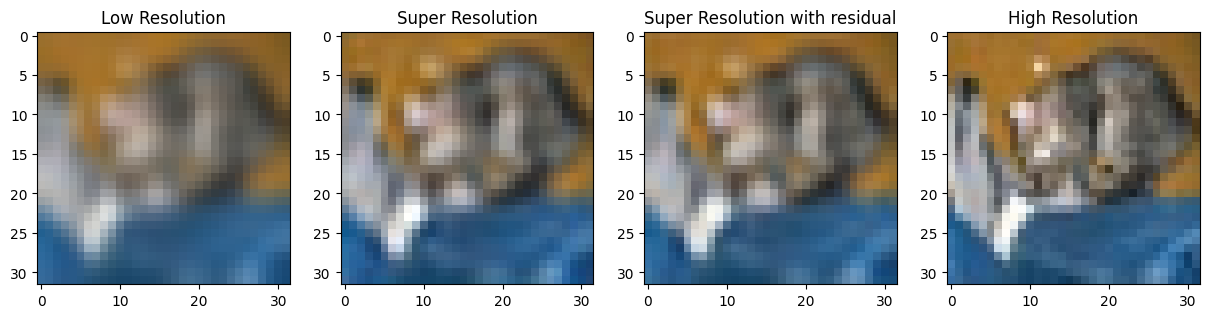

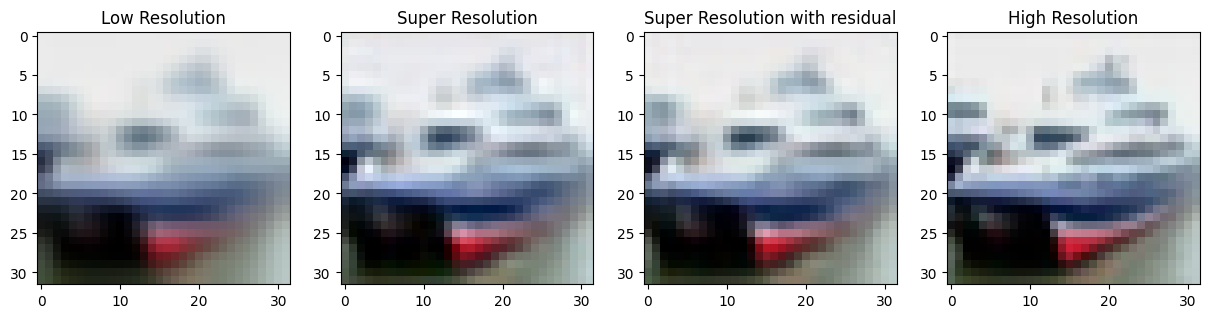

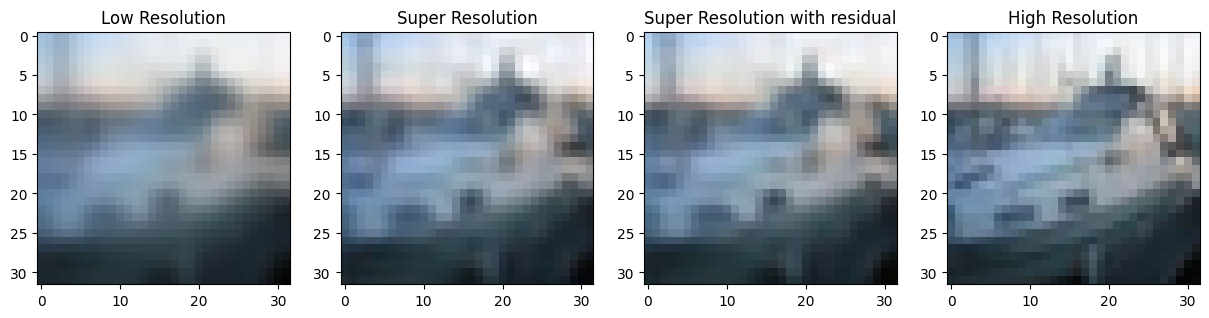

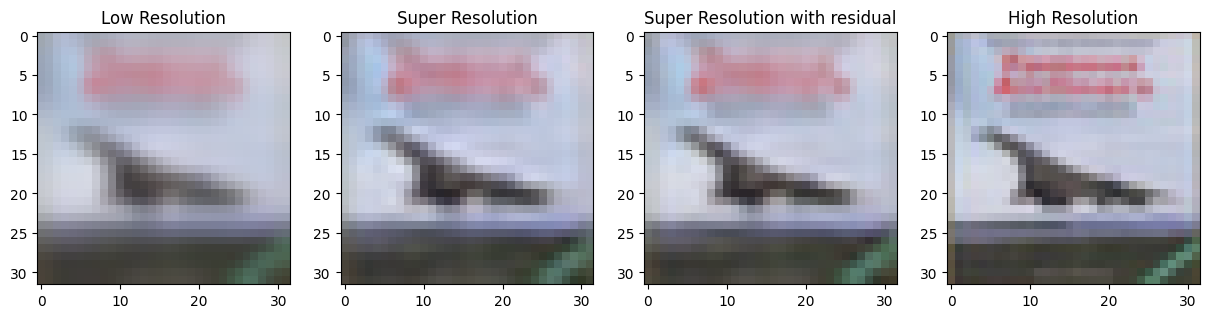

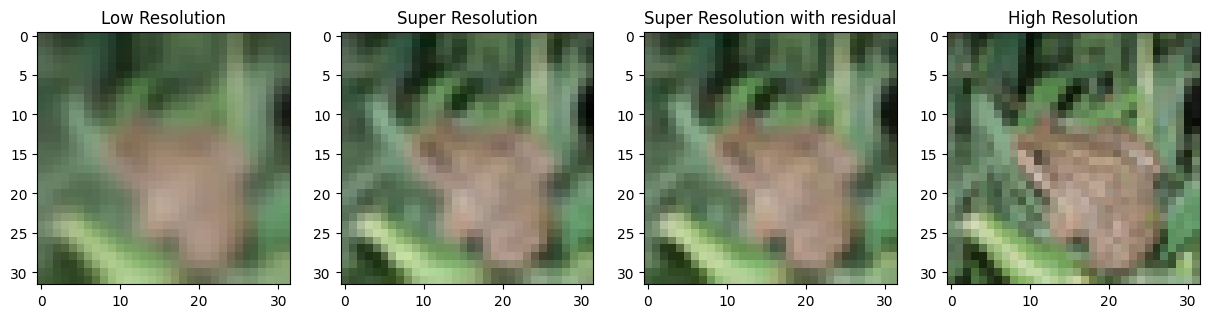

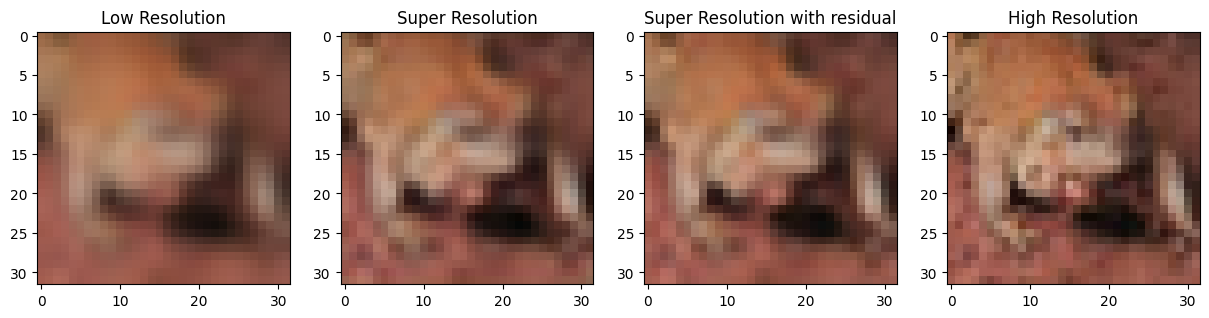

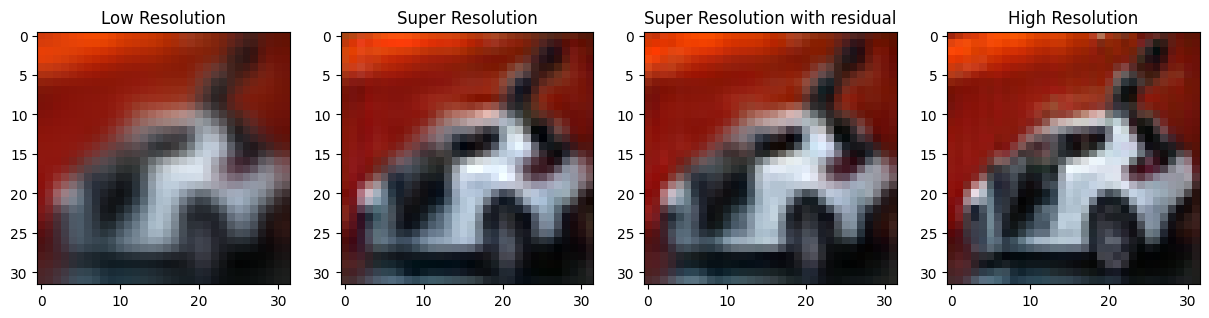

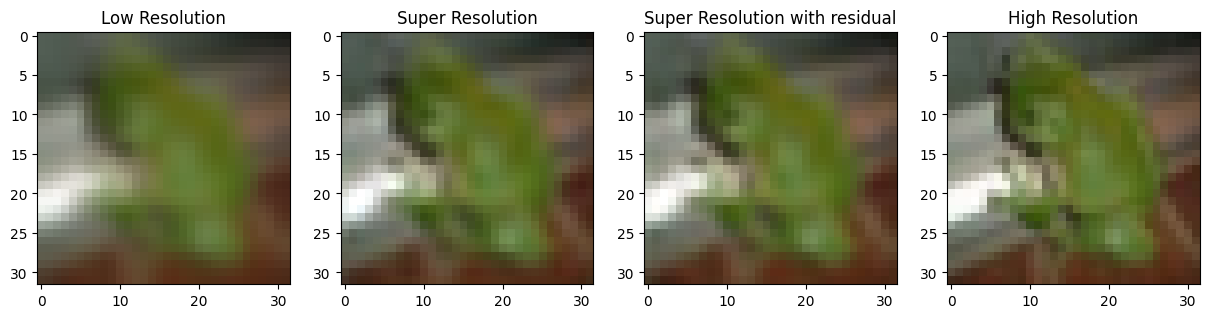

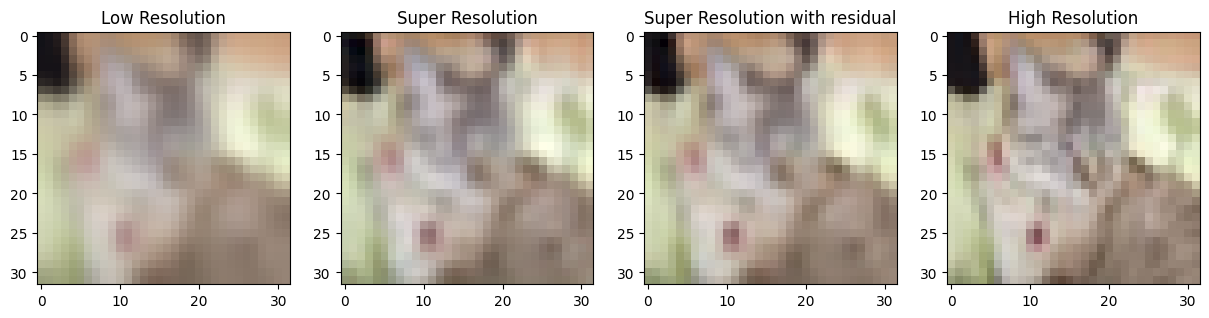

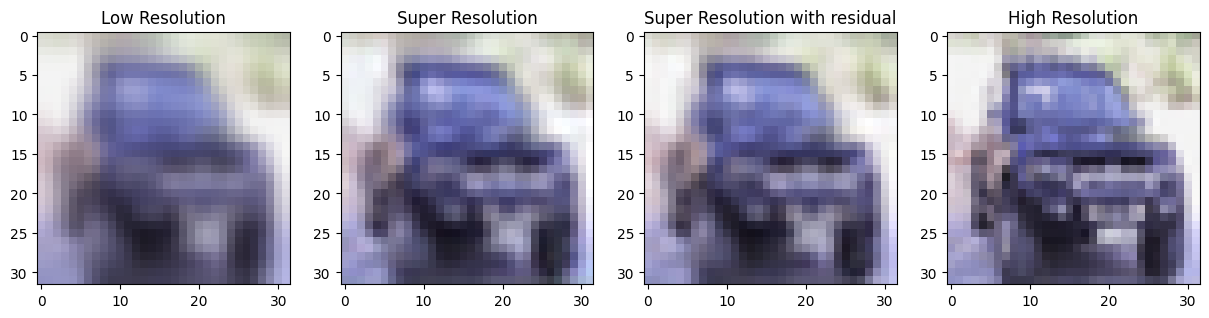

In [50]:
# 画像を可視化
def show_images2(low_res, high_res, output, output_res):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    axs[0].imshow(low_res.permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Low Resolution")
    axs[1].imshow(output.permute(1, 2, 0).detach().cpu().numpy())
    axs[1].set_title("Super Resolution")
    axs[2].imshow(output_res.permute(1, 2, 0).detach().cpu().numpy())
    axs[2].set_title("Super Resolution with residual")
    axs[3].imshow(high_res.permute(1, 2, 0).cpu().numpy())
    axs[3].set_title("High Resolution")
    plt.show()

# テスト
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        low_res, high_res = create_low_high_res_pairs(images, scale_factor)
        low_res, high_res = torch.stack(low_res).to(device), high_res.to(device)

        outputs = model(low_res)
        outputs_res = model_Res(low_res)

        # 最初の10枚を表示
        for i in range(10):
            show_images2(low_res[i], high_res[i], outputs[i], outputs_res[i])

        break

主観的な評価では、大きな差はなく。若干、スキップ接続有のほうがシャープに感じる。

In [52]:
# PSNRの計算

super_high_psnr = peak_signal_noise_ratio(high_res[0].cpu().numpy(), outputs[0].detach().cpu().numpy())
super_high_psnr_res = peak_signal_noise_ratio(high_res[0].cpu().numpy(), outputs_res[0].detach().cpu().numpy())
low_high_psnr = peak_signal_noise_ratio(high_res[0].cpu().numpy(), low_res[0].detach().cpu().numpy())

print(f"高解像度（オリジナル）と低解像度のPSNR: {low_high_psnr:.2f}  高解像度（オリジナル）と超解像画像のPSNR: {super_high_psnr:.2f} 高解像度（オリジナル）と超解像画像(残差ブロック)のPSNR: {super_high_psnr_res:.2f}")

高解像度（オリジナル）と低解像度のPSNR: 23.47  高解像度（オリジナル）と超解像画像のPSNR: 25.37 高解像度（オリジナル）と超解像画像(残差ブロック)のPSNR: 25.60


PSNRを用いた評価では、通常のSRCNNの値が25.37に対してスキップ接続有の値が25.60となっており、数値上は改善していることが確認できた。
